<a href="https://colab.research.google.com/github/abhinavtembulkar/galaxyCNNclassifier/blob/master/galaxyCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GALAXY TYPE IDENTIFIER
- Here, we are given a dataset of 21000 images of galaxies
- Our task is to classify them using CNN

## Fetching Dataset

In [1]:
! mkdir /dataset
! wget http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5 -P ./dataset

--2020-08-12 17:29:54--  http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
Resolving astro.utoronto.ca (astro.utoronto.ca)... 128.100.89.2
Connecting to astro.utoronto.ca (astro.utoronto.ca)|128.100.89.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210234548 (200M) [text/plain]
Saving to: ‘./dataset/Galaxy10.h5’

Galaxy10.h5         100%[===================>] 200.50M  30.9MB/s    in 9.4s    

2020-08-12 17:30:04 (21.3 MB/s) - ‘./dataset/Galaxy10.h5’ saved [210234548/210234548]



## Plotting images
- We are reading a .h5 file to plot images
- Plot using matplotlib

<HDF5 dataset "images": shape (21785, 69, 69, 3), type "|u1">
21785


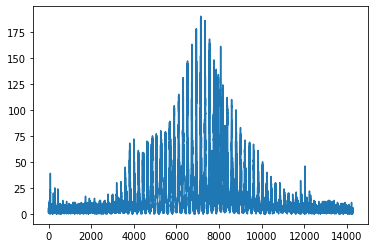

In [2]:
import h5py
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

with h5py.File('./dataset/Galaxy10.h5','r') as f:
  print(f['images'])
  images = np.array(f['images'])
  labels = np.array(f['ans'])

imag = images[random.randrange(len(images))].reshape(-1,1)
plt.plot(imag)
print(len(images))

Text(0.5, 1.0, '1')

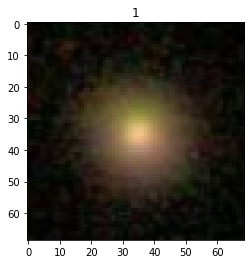

In [3]:
import random

index = random.randrange(len(images))
plt.imshow(images[index])
plt.title(str(labels[index]))

## Making Classifier ie. CNN
- We make a CNN and a fully connected layer at end
- model is very sentitve to batch size !

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,datasets
import time

In [5]:
BATCH_SIZE = 20

## Organising data into batches

In [6]:
#print(len(images[:-5]))

images = images[:-85]
labels = labels[:-85]
limit = int(0.8*len(images))

trainimages = torch.Tensor(images[:limit])
trainlabels = torch.Tensor(labels[:limit])

testimages = torch.Tensor(images[limit:])
testlabels = torch.Tensor(labels[limit:])

trains = torch.utils.data.TensorDataset(trainimages,trainlabels)
trainloader = torch.utils.data.DataLoader(trains,BATCH_SIZE,True)

tests = torch.utils.data.TensorDataset(testimages,testlabels)
testloader = torch.utils.data.DataLoader(tests,BATCH_SIZE,True)

In [7]:
images.shape

(21700, 69, 69, 3)

In [8]:
images.shape

(21700, 69, 69, 3)

In [9]:
len(tests)

4340

In [10]:
len(trains)

17360

In [11]:
print(limit)
print(len(trainloader))
print(len(testloader))

17360
868
217


## NN model

In [12]:
class galaxyCNN (nn.Module):
  def __init__(self,linear_dimen):
    super().__init__()

    #input channels are 3 , hence conv1 is 3,32
    self.conv1 = nn.Conv2d(3,32,kernel_size=2)
    self.conv2 = nn.Conv2d(32,64,kernel_size=2)
    self.conv3 = nn.Conv2d(64,128,kernel_size=2)
    self.conv4 = nn.Conv2d(128,512,kernel_size=2)

    self.linear_dimen = linear_dimen
    self.fc1 = nn.Linear(self.linear_dimen,1024)
    self.fc2 = nn.Linear(1024,10)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,kernel_size=2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,kernel_size=2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x,kernel_size=2)
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x,kernel_size=2)
    #print(x.shape/BATCH_Si)
    #self.linear_dimen=x.shape//BATCH_SIZE

    #x = x.view(-1,self.linear_dimen)
    #x = torch.flatten(x)
    x = x.view(BATCH_SIZE,self.linear_dimen)
    x = F.relu(self.fc1(x))
    y = self.fc2(x)

    return y

In [13]:
want_gpu = True
if torch.cuda.is_available() and want_gpu:
  device = torch.device('cuda:0')
  print('running on gpu')
else:
    device = torch.device('cpu')
    print('running on cpu')

running on gpu


In [14]:
#image.shape

In [15]:
galaxyModel = galaxyCNN(linear_dimen=128*6*6).to(device)
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(galaxyModel.parameters(),lr=0.0001)

In [16]:
"""
galaxyModel.conv1.requires_grad_=True
galaxyModel.conv2.requires_grad_=True
galaxyModel.conv3.requires_grad_=True
galaxyModel.conv4.requires_grad_=True

galaxyModel.fc1.requires_grad_=True
galaxyModel.fc2.requires_grad=True
"""

'\ngalaxyModel.conv1.requires_grad_=True\ngalaxyModel.conv2.requires_grad_=True\ngalaxyModel.conv3.requires_grad_=True\ngalaxyModel.conv4.requires_grad_=True\n\ngalaxyModel.fc1.requires_grad_=True\ngalaxyModel.fc2.requires_grad=True\n'

## Training model on trainset

In [17]:
from tqdm.notebook import tqdm

EPOCHS = 10
batches = iter(trainloader)
results = [[],[],[]]

correct = 0
total = 0

for e in range(EPOCHS):
  for batch in tqdm(batches):
    image,label = batch

    image = image.view(BATCH_SIZE,3,69,69)
    label = label.to(device)
    image = image.to(device)

    galaxyModel.zero_grad()
    y = galaxyModel(image)
    loss = Loss(y,label.long())

    loss.backward()
    optimizer.step()

    correct += torch.sum((torch.argmax(torch.sigmoid(y),dim=1)==label).float())
    total+=BATCH_SIZE

    results[0].append(e)
    results[1].append(loss)
    results[2].append(correct/total)

  batches = iter(trainloader)

## Testing model on testset

In [18]:
test_batches = iter(testloader)

correct = 0
total = 0

with torch.no_grad():
  for batch in tqdm(test_batches):
    image,label = batch

    image = image[:,:,:,:]
    image = image.view(BATCH_SIZE,3,69,69)
    image = image.to(device)
    label = label.to(device)

    y = galaxyModel(image)

    correct += torch.sum((torch.argmax(F.relu(y),dim=1)==label).float())
    total+=BATCH_SIZE

print("Accuracy: {} %".format((correct/total)*100))


Accuracy: 71.35945129394531 %


## Checking model accuracy on trainset

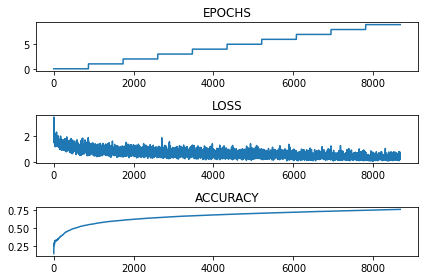

In [19]:
fig, axes = plt.subplots(3)

axes[0].plot(results[0])
axes[0].set_title('EPOCHS')

axes[1].plot(results[1])
axes[1].set_title('LOSS')

axes[2].plot(results[2])
axes[2].set_title('ACCURACY')

fig.tight_layout()
plt.show()

## Checking random images ourselves

In [20]:
indxx = random.randrange(len(images))

img = images[indxx]
img = img[:,:,:]
img = torch.cuda.FloatTensor(img).view(1,1,69,69)
y = galaxyModel(img)
print(y)

RuntimeError: ignored

tensor(156, device='cuda:0')


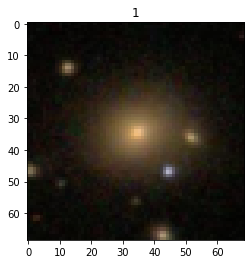

In [21]:
lbl = torch.argmax(F.relu(y))
plt.imshow(images[indxx])
plt.title(str(labels[indxx]))

print(lbl)

In [ ]:
print(F.relu(y),torch.sigmoid(y))